# Find optimal parameters for the original aggregation method

## Set up

Set up the code

In [19]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..')) # Add parent directory to path
sys.path.insert(0, module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import brier_score_loss
import scipy.optimize as optimize

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Local imports
from src import process
from src import util

data_path = process.DEFAULT_DATA_PATH

In [21]:
# Load data
blind_mode_df, estimates_df = process.load_and_process_results(
    fix_bad_rows=True, remove_bad_rows=True
)
blind_mode_feature_df = process.get_feature_df(blind_mode_df)
resolution_vector = process.get_target_df(df_format=False)

In [22]:
# Mean estimate by group
mean_ests = np.array(estimates_df.mean(axis=0))
mean_ests_SF = np.array(
    estimates_df.loc[blind_mode_df["Superforecaster"].values == "Yes"].mean(axis=0)
)
mean_ests_FE = np.array(
    estimates_df.loc[blind_mode_df["ForecastingExperience"].values == "Yes"].mean(
        axis=0
    )
)
mean_ests_LW = np.array(
    estimates_df.loc[blind_mode_df["LessWrong"].values == "Yes"].mean(axis=0)
)

## Evaluate original aggregation method

In [23]:
# Find the best individual score
estimates_matrix = process.get_estimates_matrix(blind_mode_df)
blind_mode_final_brier = np.mean(
    np.square(estimates_matrix - resolution_vector), axis=1
)
best_individual_brier = np.min(blind_mode_final_brier)
print("Best individual brier score:", best_individual_brier)

Best individual brier score: 0.11796399999999997


In [24]:
# Original aggregate prediction (verified to match 3_manifold.ipynb)
weights_original = [0.05, 0.8, 0.1, 0.05]
beta_a = 1 / 3
beta_b = 1 / 3
x0_original = weights_original + [beta_a, beta_b]
score = util.aggregation_score(
    x0_original, mean_ests, mean_ests_SF, mean_ests_FE, mean_ests_LW, resolution_vector
)
print("Original score:", score)

Original score: 0.153088


## Find optimal parameters

Evaluate brier score as a function of beta.ppf() parameters and group weight parameters

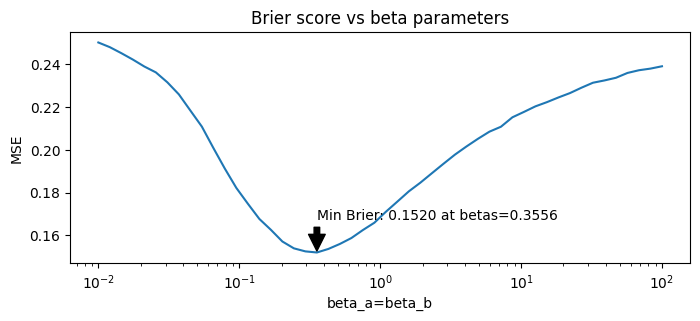

In [25]:
# Evaluate score over a parameter mesh with beta_a=beta_b and fixed weights
beta_range = np.logspace(-2, 2, 50)
parameter_mesh = util.generate_aggregate_meshgrid(
    *weights_original, beta_range, equal_betas=True
)
mse_beta = np.zeros(len(beta_range))
for i in range(len(parameter_mesh)):
    score = util.aggregation_score(
        parameter_mesh[i, :],
        mean_ests,
        mean_ests_SF,
        mean_ests_FE,
        mean_ests_LW,
        resolution_vector,
    )
    mse_beta[i] = score

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.plot(beta_range, mse_beta)
ax.set_title("Brier score vs beta parameters")
ax.set_xlabel("beta_a=beta_b")
ax.set_ylabel("MSE")
ax.set_xscale("log")
# Add annotation to minimum
min_mse_beta = np.min(mse_beta)
min_beta_a = beta_range[np.argmin(mse_beta)]
ax.annotate(
    f"Min Brier: {min_mse_beta:.4f} at betas={min_beta_a:.4f}",
    xy=(min_beta_a, min_mse_beta),
    xytext=(min_beta_a, min_mse_beta * 1.1),
    arrowprops=dict(facecolor="black", shrink=0.05),
)
plt.show()

In [26]:
# Evaluate score over a parameter mesh of beta_a and beta_b and fixed weights

# WIP
if 0:
    beta_range = np.logspace(-2, 2, 50)
    parameter_mesh = util.generate_aggregate_meshgrid(
        *weights_original, beta_range, equal_betas=False
    )
    mse_beta = np.zeros(len(beta_range), len(beta_range))
    for i in range(len(parameter_mesh)):
        score = util.aggregation_score(
            parameter_mesh[i, :],
            mean_ests,
            mean_ests_SF,
            mean_ests_FE,
            mean_ests_LW,
            resolution_vector,
        )
        mse_beta[i] = score

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    fig.colorbar(ax.imshow(mse_beta, interpolation="nearest", origin="lower"))
    ax.set_title("MSE vs beta_a and beta_b")
    ax.set_xlabel("beta_b")
    ax.set_ylabel("beta_a")

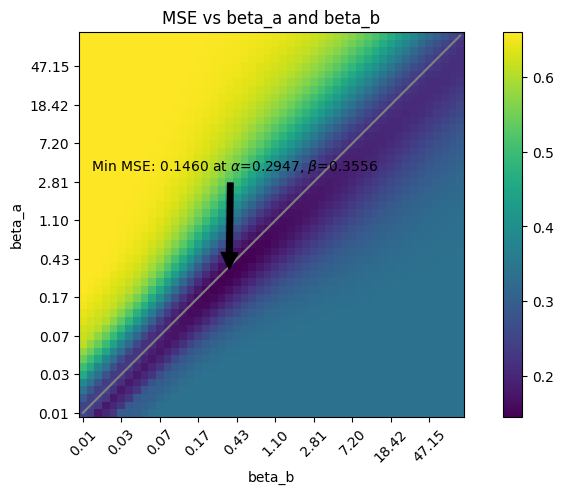

In [27]:
# Do the same, but plot a heatmap over a 2d grid of beta_a and beta_b
weighted_mean_predictions = (
    weights_original[0] * mean_ests
    + weights_original[1] * mean_ests_SF
    + weights_original[2] * mean_ests_FE
    + weights_original[3] * mean_ests_LW
)

beta_a = np.logspace(-2, 2, 50)
beta_b = np.logspace(-2, 2, 50)
mse_beta = np.zeros((len(beta_a), len(beta_b)))
for i in range(len(beta_a)):
    for j in range(len(beta_b)):
        mse_beta[i, j] = mean_squared_error(
            beta.ppf(weighted_mean_predictions / 100, beta_a[i], beta_b[j]),
            resolution_vector,
        )
# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
fig.colorbar(ax.imshow(mse_beta, interpolation="nearest", origin="lower"))
ax.set_title("MSE vs beta_a and beta_b")
ax.set_xlabel("beta_b")
ax.set_ylabel("beta_a")
# Correct the tick labels to show the actual values, but only show current number of ticks
target_ticks = 10
tick_interval = max(1, int(max(len(beta_b), len(beta_a)) / target_ticks))
# Set tick locations
ax.set_xticks(np.arange(0, len(beta_b), tick_interval))
ax.set_yticks(np.arange(0, len(beta_a), tick_interval))
# Set tick labels
ax.set_xticklabels([f"{b:.2f}" for b in beta_b[::tick_interval]], rotation=45)
ax.set_yticklabels([f"{a:.2f}" for a in beta_a[::tick_interval]])
# Add annotation of minimum value
min_idx = np.unravel_index(np.argmin(mse_beta), mse_beta.shape)
min_mse_beta = mse_beta[min_idx]
min_beta_a = beta_a[min_idx[0]]
min_beta_b = beta_b[min_idx[1]]
ax.annotate(
    rf"  Min MSE: {min_mse_beta:.4f} at $\alpha$={min_beta_a:.4f}, $\beta$={min_beta_b:.4f}",
    xy=(min_idx[1], min_idx[0]),  # x, y coordinates for annotation point
    xytext=(min_idx[1] * 0.0, min_idx[0] * 1.75),  # Adjust text position
    arrowprops=dict(facecolor="black", shrink=0.05),
)
# Add line at beta_a==beta_b
ax.plot([0, len(beta_a) - 1], [0, len(beta_a) - 1], color="grey")
plt.show()

In [28]:
# Compute f over a 6d mesh grid
# Then plot slices and dimensionality reduction PCA/TSNE

n_points = 25
fixed_betas = True
if fixed_betas:
    beta_a_axis = [1 / 3]
    beta_b_axis = [1 / 3]
else:
    beta_a_axis = np.logspace(-2, 2, n_points)
    beta_b_axis = np.logspace(-2, 2, n_points)
weights_sf_axis = np.linspace(0, 1, n_points)
weights_fe_axis = np.linspace(0, 1, n_points)
weights_lw_axis = np.linspace(0, 1, n_points)
# weights_all_axis will be computed from the other weights, so they sum to 1

# Create meshgrid
(
    beta_a_mesh,
    beta_b_mesh,
    weights_sf_mesh,
    weights_fe_mesh,
    weights_lw_mesh,
) = np.meshgrid(
    beta_a_axis, beta_b_axis, weights_sf_axis, weights_fe_axis, weights_lw_axis
)
beta_a_mesh = beta_a_mesh.flatten()
beta_b_mesh = beta_b_mesh.flatten()
weights_sf_mesh = weights_sf_mesh.flatten()
weights_fe_mesh = weights_fe_mesh.flatten()
weights_lw_mesh = weights_lw_mesh.flatten()
weights_all_mesh = np.array(
    [
        1 - weights_sf_mesh - weights_fe_mesh - weights_lw_mesh,
        weights_sf_mesh,
        weights_fe_mesh,
        weights_lw_mesh,
        beta_a_mesh,
        beta_b_mesh,
    ]
).T

# Remove any rows where the weights are negative
weights_all_mesh = weights_all_mesh[(weights_all_mesh >= 0).all(axis=1)]
print(f"Number of points in meshgrid: {len(weights_all_mesh)}")

# Compute f over the meshgrid
from numba import njit, jit, cuda


# Suppress jit warnings
@jit(nopython=True, parallel=True)
def compute_mesh_f(weights_all_mesh, ests_none, ests_SF, ests_FE, ests_LW):
    f_mesh = np.ones(len(weights_all_mesh))
    for i in range(len(weights_all_mesh)):
        f_mesh[i] = util.aggregation_score(
            weights_all_mesh[i], ests_none, ests_SF, ests_FE, ests_LW, resolution_vector
        )
    return f_mesh


use_accelerator = False  # Not working yet
if use_accelerator:
    f_mesh = compute_mesh_f(
        weights_all_mesh,
        mean_ests,
        mean_ests_SF,
        mean_ests_FE,
        mean_ests_LW,
        resolution_vector,
    )
else:
    f_mesh = np.ones(len(weights_all_mesh))
    for i in range(len(weights_all_mesh)):
        f_mesh[i] = util.aggregation_score(
            weights_all_mesh[i],
            mean_ests,
            mean_ests_SF,
            mean_ests_FE,
            mean_ests_LW,
            resolution_vector,
        )

Number of points in meshgrid: 2923


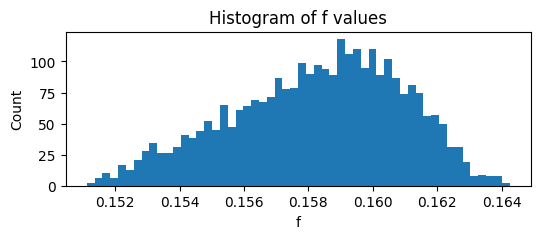

In [29]:
# Historam of f values
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.hist(f_mesh, bins=np.round(np.sqrt(len(f_mesh))).astype(int))
ax.set_title("Histogram of f values")
ax.set_xlabel("f")
ax.set_ylabel("Count")
plt.show()

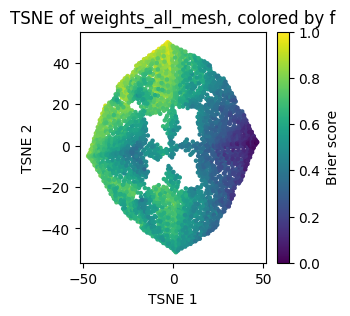

In [30]:
# Calculate TSNE of weights_all_mesh, colored by f
tsne = TSNE(n_components=2, random_state=0)
tsne_weights = tsne.fit_transform(weights_all_mesh)
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(tsne_weights[:, 0], tsne_weights[:, 1], s=5, c=f_mesh, cmap="viridis")
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
ax.set_title("TSNE of weights_all_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()

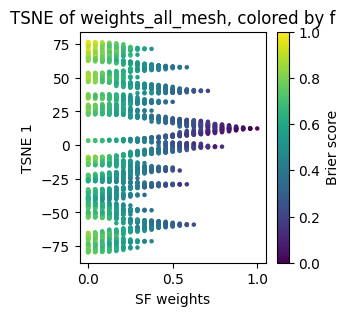

In [31]:
# Calculate a 1-d TSNE without the 2nd dimension of weights_all_mesh, then plot
# the third dimension against the 1-d TSNE
tsne = TSNE(n_components=1, random_state=0)
tsne_weights = tsne.fit_transform(weights_all_mesh[:, [0, 2, 3, 4, 5]])
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(weights_all_mesh[:, 1], tsne_weights[:, 0], s=5, c=f_mesh, cmap="viridis")
ax.set_xlabel("SF weights")
ax.set_ylabel("TSNE 1")
ax.set_title("TSNE of weights_all_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()

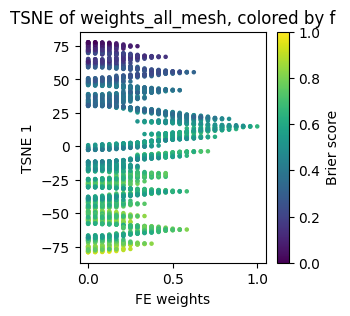

In [32]:
# Calculate a 1-d TSNE without the 2nd dimension of weights_all_mesh, then plot
# the third dimension against the 1-d TSNE
tsne = TSNE(n_components=1, random_state=0)
tsne_weights = tsne.fit_transform(weights_all_mesh[:, [0, 1, 3, 4, 5]])
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(weights_all_mesh[:, 2], tsne_weights[:, 0], s=5, c=f_mesh, cmap="viridis")
ax.set_xlabel("FE weights")
ax.set_ylabel("TSNE 1")
ax.set_title("TSNE of weights_all_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()

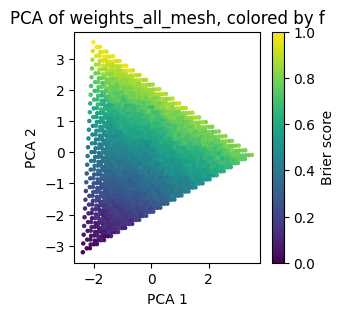

In [33]:
# Calculate PCA of weights_all_mesh, colored by f
normalize_data = True
if normalize_data:
    pca_mesh = StandardScaler().fit_transform(weights_all_mesh)
else:
    pca_mesh = weights_all_mesh
pca = PCA(n_components=2)
pca_weights = pca.fit_transform(pca_mesh)
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(pca_weights[:, 0], pca_weights[:, 1], s=5, c=f_mesh, cmap="viridis")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title("PCA of weights_all_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()

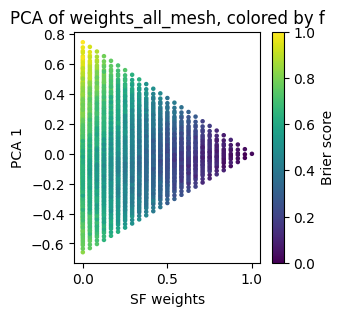

In [34]:
# Calculate a 1-d PCA without the third dimension of weights_all_mesh, then plot
# the third dimension against the 1-d PCA
pca = PCA(n_components=1)
pca_weights = pca.fit_transform(weights_all_mesh[:, [0, 2, 3, 4, 5]])
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(weights_all_mesh[:, 1], pca_weights[:, 0], s=5, c=f_mesh, cmap="viridis")
ax.set_xlabel("SF weights")
ax.set_ylabel("PCA 1")
ax.set_title("PCA of weights_all_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()


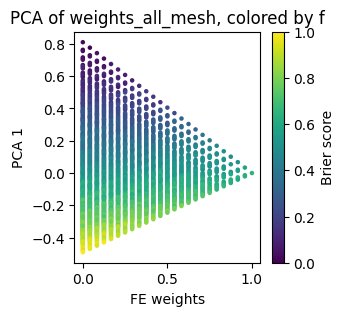

In [35]:
# Calculate a 1-d PCA without the third dimension of weights_all_mesh, then plot
# the third dimension against the 1-d PCA
pca = PCA(n_components=1)
pca_weights = pca.fit_transform(weights_all_mesh[:, [0, 1, 3, 4, 5]])
# Plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.scatter(weights_all_mesh[:, 2], pca_weights[:, 0], s=5, c=f_mesh, cmap="viridis")
ax.set_xlabel("FE weights")
ax.set_ylabel("PCA 1")
ax.set_title("PCA of weights_all_mesh, colored by f")
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=ax, label="Brier score")
plt.show()

## Optimized parameters

Use scipy optimize to find the optimal parameters

In [36]:
# Optimize the weights and beta_a, beta_b simultaneously

# Initial guess
weights_original = [0.05, 0.8, 0.1, 0.05]
weights = [0.25, 0.25, 0.25, 0.25]
beta_a = 1 / 3
beta_b = 1 / 3
x0 = weights + [beta_a, beta_b]
x0_original = weights_original + [beta_a, beta_b]
constraints = ({"type": "eq", "fun": util.aggregation_constraint_1},)
arguments = (mean_ests, mean_ests_SF, mean_ests_FE, mean_ests_LW, resolution_vector)
bounds = (
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (1 / 10, 1),
    (1 / 10, 1),
)

x0_original_string = ", ".join([f"{p:.6f}" for p in x0_original])
print(f"Original guess: {x0_original_string}")
x0_score = util.aggregation_score(x0_original, *arguments)
print(f"Score: {x0_score:.6f}")

# SciPy.optimize.minimize
print("Local optimization using minimize")
result = optimize.minimize(
    util.aggregation_score,
    x0,
    constraints=constraints,
    bounds=bounds,
    args=arguments,
    tol=1e-3,
    # method="Nelder-Mead",
    options={"maxiter": 1000000},
)

if result.success:
    fitted_params = result.x
    param_string = ", ".join([f"{p:.6f}" for p in fitted_params])
    print(f"Fitted params:  {param_string}")
    fitted_param_score = result.fun
    print(f"Score: {fitted_param_score:.6f}")
else:
    raise ValueError(result.message)

# Scipy.optimize.basinhopping
print("Global optimization")
optimization_method = "dual_annealing"
match optimization_method:
    case "basinhopping":
        result = optimize.basinhopping(
            util.validated_aggregation_score,
            x0,
            minimizer_kwargs={
                "bounds": bounds,
                "args": arguments,
            },
            niter=1000,
            disp=False,
            stepsize=0.01,
        )
    case "dual_annealing":
        result = optimize.dual_annealing(
            util.validated_aggregation_score,
            bounds,
            args=arguments,
            minimizer_kwargs={
                "constraints": constraints,
                "bounds": bounds,
            },
            maxiter=5000,  # High number of iterations
            initial_temp=5230,  # Default 5230
            # restart_temp_ratio=0.005,  # Low restart temperature ratio
            # visit=2.5,  # Default 2.62
            accept=-1e4,  # Higher acceptance of worse solutions
            maxfun=1e8,  # Default 1e7
            seed=1,
        )
    case _:
        raise ValueError(f"Unknown optimization method: {optimization_method}")

if result.success:
    fitted_params = result.x
    param_string = ", ".join([f"{p:.6f}" for p in fitted_params])
    print(f"Fitted params:  {param_string}")
    fitted_param_score = result.fun
    print(f"Score: {fitted_param_score:.6f}")
else:
    raise ValueError(result.message)

# Best so far:
# Fitted params:  0.343751, 0.656249, 0.000000, 0.000000, 0.316564, 0.381792
# Score: 0.146116

Original guess: 0.050000, 0.800000, 0.100000, 0.050000, 0.333333, 0.333333
Score: 0.153088
Local optimization using minimize
Fitted params:  0.250000, 0.250000, 0.250000, 0.250000, 0.333333, 0.333333
Score: 0.158232
Global optimization
Fitted params:  0.000000, 0.722385, 0.082014, 0.195602, 0.227142, 0.276849
Score: 0.147730
